In [1]:
!git clone https://github.com/LeeErGou996/MaskRCNN.git
!pip install matplotlib Pillow tqdm
# !pip install torch==2.0.1 torchvision==0.15.2



fatal: destination path 'MaskRCNN' already exists and is not an empty directory.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
os.chdir('/content/MaskRCNN')


Removing existing directory: ./train
Removing existing directory: ./val
Removing existing directory: ./test
Created fresh dataset directories.
Found 8 images and 8 masks in source directory
Class distribution in the dataset:
 - Class BAS: 1 images
 - Class EBO: 1 images
 - Class EOS: 1 images
 - Class LYT: 1 images
 - Class MON: 1 images
 - Class MYO: 1 images
 - Class NGB: 1 images
 - Class NGS: 1 images

Final class distribution in training set:
 - Class EOS: 1 images
 - Class MON: 1 images
 - Class MYO: 1 images
 - Class NGS: 1 images

Final class distribution in validation set:
 - Class BAS: 1 images
 - Class NGB: 1 images

Final class distribution in test set:
 - Class EBO: 1 images
 - Class LYT: 1 images

Dataset split complete:
 - Training set: 4/4 images copied
 - Validation set: 2/2 images copied
 - Test set: 2/2 images copied
Using device: cuda
Dataset sizes: Train=4, Val=2, Test=2


Training Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training Batch:   0%|          | 0/2 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

creating index...
index created!
Averaged stats: model_time: 0.3947 (0.3947)  evaluator_time: 0.0039 (0.0039)
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall    

Testing:   0%|          | 0/1 [00:00<?, ?it/s]

creating index...
index created!
Averaged stats: model_time: 0.3913 (0.3913)  evaluator_time: 0.0020 (0.0020)
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.072
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.500
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.072
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.050
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.250
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.250
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall    

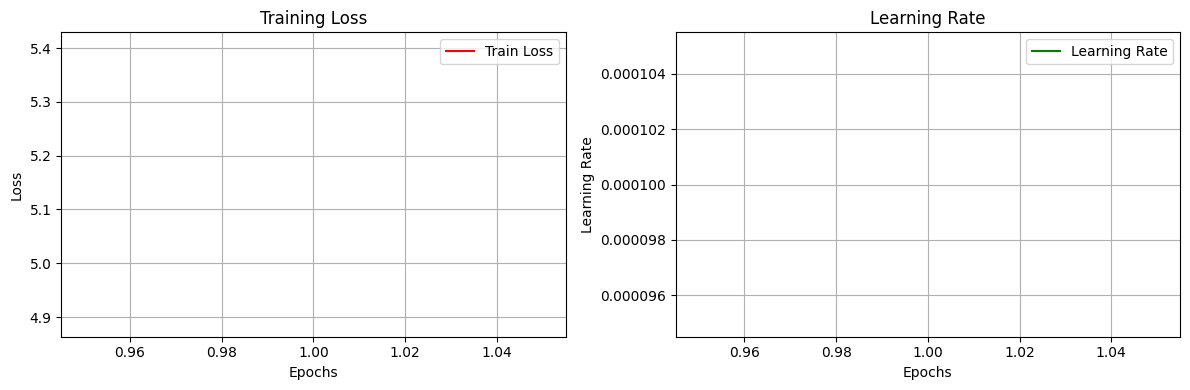

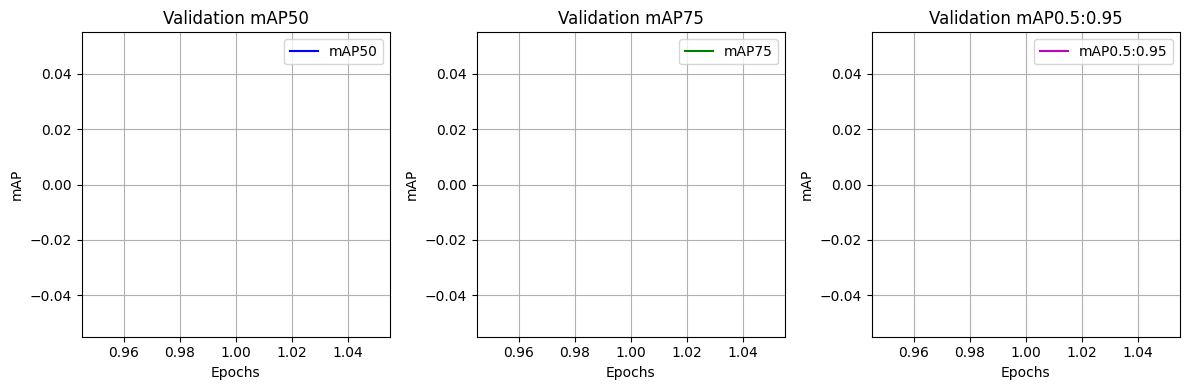

In [7]:
import os
import sys
import time
import numpy as np
import torch
from PIL import Image
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor, MaskRCNN_ResNet50_FPN_Weights
import matplotlib.pyplot as plt
from datetime import datetime

# Import custom modules (assuming these are available in your environment)
# You'll need to implement or obtain these modules separately
from detection.engine import train_one_epoch, evaluate
import detection.utils as utils
import detection.transforms as T
from mymaskrcnn import custom_maskrcnn_resnet50_fpn


class PennFudanDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms

        # Define class mapping
        self.CLASSES = {
            'EOS': 1,
            'LYT': 2,
            'MON': 3,
            'MYO': 4,
            'NGB': 5,
            'NGS': 6,
            'EBO': 7,
            'BAS': 8
        }  # Background is 0, target classes start from 1

        # Match image and mask files
        self.imgs = list(sorted([f for f in os.listdir(os.path.join(root, "PNGImages")) if f.endswith(('.png', '.jpg'))]))
        self.masks = list(sorted([f for f in os.listdir(os.path.join(root, "PedMasks")) if f.endswith(('.png', '.jpg'))]))

        if len(self.imgs) != len(self.masks):
            raise ValueError(f"Number of images ({len(self.imgs)}) and masks ({len(self.masks)}) do not match!")

        for img, mask in zip(self.imgs, self.masks):
            if os.path.splitext(img)[0] != os.path.splitext(mask)[0]:
                raise ValueError(f"Mismatch between image and mask: {img} and {mask}")

    def get_class_from_filename(self, filename):
        class_name = filename.split('_')[0]
        if class_name not in self.CLASSES:
            print(f"Warning: Class name '{class_name}' not found in CLASSES. Defaulting to background (0).")
        return self.CLASSES.get(class_name, 0)

    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        mask_name = self.masks[idx]

        img_path = os.path.join(self.root, "PNGImages", img_name)
        mask_path = os.path.join(self.root, "PedMasks", mask_name)

        # Open image and mask with PIL
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        mask = np.array(mask)  # Convert mask to numpy array

        # Get class label
        class_id = self.get_class_from_filename(img_name)

        # Combine all masks into one
        combined_mask = (mask > 0).astype(np.uint8)
        pos = np.where(combined_mask)

        if pos[0].size == 0 or pos[1].size == 0:
            raise ValueError(f"Invalid mask at index {idx}")

        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])

        # Create bounding box and mask
        boxes = torch.tensor([[xmin, ymin, xmax, ymax]], dtype=torch.float32)
        masks = torch.as_tensor(combined_mask, dtype=torch.uint8).unsqueeze(0)
        labels = torch.tensor([class_id], dtype=torch.int64)

        # Prepare target dictionary
        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": torch.tensor([idx]),
            "area": (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
            "iscrowd": torch.zeros((1,), dtype=torch.int64),
        }

        # Apply transformations if defined
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)


def get_model_instance_segmentation(num_classes):
    # Load a pre-trained model
    model = custom_maskrcnn_resnet50_fpn(weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT)

    # Replace the classifier with a new one for num_classes
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Replace the mask predictor with a new one for num_classes
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    return model


def get_transform(train):
    transforms = [T.ToTensor()]
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)


def train_model(train_dir, val_dir, test_dir, output_dir, num_epochs=10):
    """
    Train the Mask R-CNN model and evaluate on validation and test sets.
    Added tqdm progress bars for better progress tracking.

    Args:
        train_dir: Directory containing training data
        val_dir: Directory containing validation data
        test_dir: Directory containing test data
        output_dir: Directory to save model and results
        num_epochs: Number of training epochs
    """
    # Import tqdm
    from tqdm.auto import tqdm

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Check if GPU is available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print(f"Using device: {device}")

    # Number of classes (background + 8 object classes)
    num_classes = 9

    # Load datasets
    dataset = PennFudanDataset(train_dir, get_transform(train=True))
    dataset_val = PennFudanDataset(val_dir, get_transform(train=False))
    dataset_test = PennFudanDataset(test_dir, get_transform(train=False))

    print(f"Dataset sizes: Train={len(dataset)}, Val={len(dataset_val)}, Test={len(dataset_test)}")

    # Create data loaders with 0 workers to avoid multiprocessing issues
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, num_workers=0, collate_fn=utils.collate_fn
    )
    data_loader_val = torch.utils.data.DataLoader(
        dataset_val, batch_size=2, shuffle=False, num_workers=0, collate_fn=utils.collate_fn
    )
    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=2, shuffle=False, num_workers=0, collate_fn=utils.collate_fn
    )

    # Initialize model
    model = get_model_instance_segmentation(num_classes)
    model.to(device)

    # Optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0008)

    # Learning rate scheduler with warmup
    import math
    def warmup_lr_lambda(current_step):
        warmup_steps = 3  # Number of warmup epochs
        if current_step < warmup_steps:
            return 0.1 + (1.0 - 0.1) * current_step / warmup_steps
        else:
            # Cosine annealing after warmup
            decay_steps = num_epochs - warmup_steps
            cosine_decay = 0.5 * (1 + math.cos(math.pi * (current_step - warmup_steps) / decay_steps))
            return max(0.1, cosine_decay)  # Lower limit is 10% of initial LR

    lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=warmup_lr_lambda)

    # Initialize tracking variables
    best_eval_metric = float('-inf')
    train_loss = []
    learning_rates = []
    val_maps = []
    val_maps_75 = []
    val_maps_all = []

    # Create log files
    now = datetime.now().strftime("%Y%m%d-%H%M%S")
    det_results_file = os.path.join(output_dir, f"det_results_{now}.txt")
    seg_results_file = os.path.join(output_dir, f"seg_results_{now}.txt")
    test_log_file = os.path.join(output_dir, f"test_log_{now}.txt")
    metrics_summary_file = os.path.join(output_dir, f"metrics_summary.txt")
    train_log_file = os.path.join(output_dir, f"train_log_{now}.txt")

    start_time = time.time()

    # Progress bar for epochs
    epoch_pbar = tqdm(range(num_epochs), desc="Training Progress", position=0)

    for epoch in epoch_pbar:
        # Update progress bar description
        epoch_pbar.set_description(f"Epoch {epoch + 1}/{num_epochs}")

        # Training phase
        model.train()

        # Modified training loop with progress bar
        train_loss_epoch = 0.0
        batch_count = 0

        # Progress bar for batches
        batch_pbar = tqdm(data_loader, desc=f"Training Batch", position=1, leave=False)

        for images, targets in batch_pbar:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Clear gradients
            optimizer.zero_grad()

            # Forward pass and compute loss
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            # Backward pass and optimize
            losses.backward()
            optimizer.step()

            # Update batch progress bar
            batch_pbar.set_postfix(loss=f"{losses.item():.4f}")

            # Accumulate loss
            train_loss_epoch += losses.item()
            batch_count += 1

        # Calculate average loss for the epoch
        mean_loss = train_loss_epoch / batch_count if batch_count > 0 else 0
        train_loss.append(mean_loss)

        # Update learning rate
        lr = optimizer.param_groups[0]["lr"]
        learning_rates.append(lr)
        lr_scheduler.step()

        # Update epoch progress bar
        epoch_pbar.set_postfix(loss=f"{mean_loss:.4f}", lr=f"{lr:.6f}")

    # In the train_model function, modify the validation part:

    # Validation phase
    model.eval()

    # Progress bar for validation
    val_pbar = tqdm(data_loader_val, desc=f"Validating", position=1, leave=False)

    with torch.no_grad():
        # Perform COCO evaluation
        eval_result_val = evaluate(model, data_loader_val, device=device)

        # Extract validation metrics with error handling
        try:
            # Try to get both bbox and segm metrics
            val_det_metric = eval_result_val.coco_eval['bbox'].stats[1]  # AP50
            val_seg_metric = eval_result_val.coco_eval['segm'].stats[1] if 'segm' in eval_result_val.coco_eval else 0.0

            val_det_metric_75 = eval_result_val.coco_eval['bbox'].stats[2]  # AP75
            val_seg_metric_75 = eval_result_val.coco_eval['segm'].stats[2] if 'segm' in eval_result_val.coco_eval else 0.0

            val_det_metric_all = eval_result_val.coco_eval['bbox'].stats[0]  # AP0.5:0.95
            val_seg_metric_all = eval_result_val.coco_eval['segm'].stats[0] if 'segm' in eval_result_val.coco_eval else 0.0
        except (KeyError, IndexError) as e:
            print(f"Warning: Could not extract some metrics from validation evaluation: {e}")
            # Provide default values for missing metrics
            if 'bbox' not in eval_result_val.coco_eval:
                val_det_metric = val_det_metric_75 = val_det_metric_all = 0.0
                print("Detection metrics missing")
            if 'segm' not in eval_result_val.coco_eval:
                val_seg_metric = val_seg_metric_75 = val_seg_metric_all = 0.0
                print("Segmentation metrics missing - this may be normal if model doesn't predict masks")

        # Compute combined metric
        current_metric = (val_det_metric + val_seg_metric) / 2
        val_maps.append(current_metric)
        val_maps_75.append((val_det_metric_75 + val_seg_metric_75) / 2)
        val_maps_all.append((val_det_metric_all + val_seg_metric_all) / 2)

        # Update epoch progress bar with validation metrics
        epoch_pbar.set_postfix(loss=f"{mean_loss:.4f}", val_mAP50=f"{current_metric:.4f}")

        # Save best model
        if current_metric > best_eval_metric:
            best_eval_metric = current_metric
            torch.save(model.state_dict(), os.path.join(output_dir, "best_model.pth"))
            print(f"\nSaved best model with mAP50: {best_eval_metric:.4f}")

        # Log training and validation info
        with open(train_log_file, "a") as f:
            f.write(f"Epoch {epoch + 1}: Train Loss: {mean_loss:.4f}, "
                   f"Val Det mAP50: {val_det_metric:.4f}, Val Seg mAP50: {val_seg_metric:.4f}, "
                   f"Val Det mAP75: {val_det_metric_75:.4f}, Val Seg mAP75: {val_seg_metric_75:.4f}, "
                   f"Val Det mAP0.5:0.95: {val_det_metric_all:.4f}, Val Seg mAP0.5:0.95: {val_seg_metric_all:.4f}\n")

    # Close progress bars
    epoch_pbar.close()

    print("\nTraining completed! Loading best model for testing...")

    # Load the best model for testing
    model.load_state_dict(torch.load(os.path.join(output_dir, "best_model.pth")))
    model.eval()

    # Test phase with progress bar
    print("Evaluating on test set...")
    test_pbar = tqdm(data_loader_test, desc="Testing")

    # Evaluate on test set
    eval_result_test = evaluate(model, data_loader_test, device=device)

    # Extract test metrics with error handling
    try:
        # Try to get both bbox and segm metrics
        test_det_metric = eval_result_test.coco_eval['bbox'].stats[1]  # AP50
        test_seg_metric = eval_result_test.coco_eval['segm'].stats[1] if 'segm' in eval_result_test.coco_eval else 0.0

        test_det_metric_75 = eval_result_test.coco_eval['bbox'].stats[2]  # AP75
        test_seg_metric_75 = eval_result_test.coco_eval['segm'].stats[2] if 'segm' in eval_result_test.coco_eval else 0.0

        test_det_metric_all = eval_result_test.coco_eval['bbox'].stats[0]  # AP0.5:0.95
        test_seg_metric_all = eval_result_test.coco_eval['segm'].stats[0] if 'segm' in eval_result_test.coco_eval else 0.0
    except (KeyError, IndexError) as e:
        print(f"Warning: Could not extract some metrics from test evaluation: {e}")
        # Provide default values for missing metrics
        if 'bbox' not in eval_result_test.coco_eval:
            test_det_metric = test_det_metric_75 = test_det_metric_all = 0.0
            print("Detection metrics missing")
        if 'segm' not in eval_result_test.coco_eval:
            test_seg_metric = test_seg_metric_75 = test_seg_metric_all = 0.0
            print("Segmentation metrics missing - this may be normal if model doesn't predict masks")

    # Save test results
    with open(test_log_file, "w") as f:
        f.write(f"Test Results - Detection mAP50: {test_det_metric:.4f}, Segmentation mAP50: {test_seg_metric:.4f}\n")
        f.write(f"Test Results - Detection mAP75: {test_det_metric_75:.4f}, Segmentation mAP75: {test_seg_metric_75:.4f}\n")
        f.write(f"Test Results - Detection mAP0.5:0.95: {test_det_metric_all:.4f}, Segmentation mAP0.5:0.95: {test_seg_metric_all:.4f}\n")

    # Save summary metrics
    with open(metrics_summary_file, "w") as f:
        f.write(f"Best Validation mAP50: {best_eval_metric:.4f}\n")
        f.write(f"Final Validation - Detection mAP50: {val_det_metric:.4f}, Segmentation mAP50: {val_seg_metric:.4f}\n")
        f.write(f"Final Validation - Detection mAP75: {val_det_metric_75:.4f}, Segmentation mAP75: {val_seg_metric_75:.4f}\n")
        f.write(f"Final Validation - Detection mAP0.5:0.95: {val_det_metric_all:.4f}, Segmentation mAP0.5:0.95: {val_seg_metric_all:.4f}\n")
        f.write(f"Test Results - Detection mAP50: {test_det_metric:.4f}, Segmentation mAP50: {test_seg_metric:.4f}\n")
        f.write(f"Test Results - Detection mAP75: {test_det_metric_75:.4f}, Segmentation mAP75: {test_seg_metric_75:.4f}\n")
        f.write(f"Test Results - Detection mAP0.5:0.95: {test_det_metric_all:.4f}, Segmentation mAP0.5:0.95: {test_seg_metric_all:.4f}\n")

    print(f"\nTest Results:")
    print(f"Detection mAP50: {test_det_metric:.4f}, Segmentation mAP50: {test_seg_metric:.4f}")
    print(f"Detection mAP75: {test_det_metric_75:.4f}, Segmentation mAP75: {test_seg_metric_75:.4f}")
    print(f"Detection mAP0.5:0.95: {test_det_metric_all:.4f}, Segmentation mAP0.5:0.95: {test_seg_metric_all:.4f}")

    # Plot training curves
    try:
        print("Generating training curves...")
        # Loss and learning rate curves
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(range(1, num_epochs + 1), train_loss, 'r', label='Train Loss')
        plt.grid(True)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(range(1, num_epochs + 1), learning_rates, 'g', label='Learning Rate')
        plt.grid(True)
        plt.xlabel('Epochs')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate')
        plt.legend()

        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'loss_lr_curve.png'))

        # mAP curves
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.plot(range(1, num_epochs + 1), val_maps, 'b', label='mAP50')
        plt.grid(True)
        plt.xlabel('Epochs')
        plt.ylabel('mAP')
        plt.title('Validation mAP50')
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(range(1, num_epochs + 1), val_maps_75, 'g', label='mAP75')
        plt.grid(True)
        plt.xlabel('Epochs')
        plt.ylabel('mAP')
        plt.title('Validation mAP75')
        plt.legend()

        plt.subplot(1, 3, 3)
        plt.plot(range(1, num_epochs + 1), val_maps_all, 'm', label='mAP0.5:0.95')
        plt.grid(True)
        plt.xlabel('Epochs')
        plt.ylabel('mAP')
        plt.title('Validation mAP0.5:0.95')
        plt.legend()

        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'map_curves.png'))

        print(f"Training curves saved to {output_dir}")
    except Exception as e:
        print(f"Failed to plot training curves: {e}")

    # Calculate training time
    total_time = time.time() - start_time
    hours, remainder = divmod(total_time, 3600)
    minutes, seconds = divmod(remainder, 60)
    print(f"Total training time: {int(hours)}h {int(minutes)}m {int(seconds)}s")

    # Return metrics
    val_metrics = (val_det_metric, val_seg_metric, val_det_metric_75, val_seg_metric_75, val_det_metric_all, val_seg_metric_all)
    test_metrics = (test_det_metric, test_seg_metric, test_det_metric_75, test_seg_metric_75, test_det_metric_all, test_seg_metric_all)

    return model, best_eval_metric, val_metrics, test_metrics

def visualize_prediction(model, image_path, device=None, score_threshold=0.5):
    """
    Visualize prediction from the Mask R-CNN model on a single image.

    Args:
        model: Trained Mask R-CNN model
        image_path: Path to the image file
        device: Computation device (CPU/GPU)
        score_threshold: Threshold for object detection score
    """
    if device is None:
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    # Set model to evaluation mode
    model.eval()

    # Load and transform image
    image = Image.open(image_path).convert("RGB")
    transform = T.ToTensor()
    image_tensor = transform(image)[0]

    # Move image to device and perform inference
    with torch.no_grad():
        prediction = model([image_tensor.to(device)])

    # Convert image back to numpy for visualization
    image_np = image_tensor.cpu().numpy().transpose(1, 2, 0)

    # Get prediction for the image
    boxes = prediction[0]['boxes'].cpu().numpy()
    scores = prediction[0]['scores'].cpu().numpy()
    labels = prediction[0]['labels'].cpu().numpy()
    masks = prediction[0]['masks'].cpu().numpy()

    # Filter predictions based on score threshold
    valid_indices = scores >= score_threshold
    boxes = boxes[valid_indices]
    scores = scores[valid_indices]
    labels = labels[valid_indices]
    masks = masks[valid_indices]

    # Visualize predictions
    plt.figure(figsize=(12, 8))

    # Show original image
    plt.subplot(1, 2, 1)
    plt.imshow(image_np)
    plt.title("Original Image")
    plt.axis('off')

    # Show image with predictions
    plt.subplot(1, 2, 2)
    plt.imshow(image_np)

    # Define colors for different classes
    colors = plt.cm.tab10(np.linspace(0, 1, 10))

    # Draw masks and boxes
    for i in range(len(boxes)):
        mask = masks[i, 0] > 0.5
        label = labels[i]
        score = scores[i]

        color = colors[label % len(colors)]

        # Draw mask
        masked_image = np.copy(image_np)
        masked_image[mask] = masked_image[mask] * 0.7 + color[:3] * 0.3
        plt.imshow(masked_image)

        # Draw bounding box
        x1, y1, x2, y2 = boxes[i].astype(int)
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                          fill=False, color=color[:3], linewidth=2))

        # Add label and score
        plt.text(x1, y1-5, f"Class {label}: {score:.2f}",
                 color='white', backgroundcolor=color[:3], fontsize=8)

    plt.title("Predictions")
    plt.axis('off')

    plt.tight_layout()
    return plt


def initialize_dataset(data_root, train_dir, val_dir, test_dir, train_size=100, val_size=50, test_size=50, min_images_per_class=1):
    """
    Initialize dataset directories for training, validation, and testing with size limits.
    If dataset directories already exist, they will be deleted and recreated.

    Args:
        data_root: Root directory containing images and masks
        train_dir: Directory to store training data
        val_dir: Directory to store validation data
        test_dir: Directory to store test data
        train_size: Maximum number of images for training set
        val_size: Maximum number of images for validation set
        test_size: Maximum number of images for test set
        min_images_per_class: Minimum number of images per class in each set
    """
    import os
    import shutil
    import random
    from collections import defaultdict

    # Check if dataset directories already exist and delete them if they do
    def clean_directory(directory):
        if os.path.exists(directory):
            print(f"Removing existing directory: {directory}")
            shutil.rmtree(directory)
        os.makedirs(directory, exist_ok=True)

    # Clean and recreate main directories
    clean_directory(train_dir)
    clean_directory(val_dir)
    clean_directory(test_dir)

    # Source directories
    src_images_dir = os.path.join(data_root, 'PNGImages')
    src_masks_dir = os.path.join(data_root, 'PedMasks')

    # Destination directories
    dst_train_images_dir = os.path.join(train_dir, 'PNGImages')
    dst_train_masks_dir = os.path.join(train_dir, 'PedMasks')
    dst_val_images_dir = os.path.join(val_dir, 'PNGImages')
    dst_val_masks_dir = os.path.join(val_dir, 'PedMasks')
    dst_test_images_dir = os.path.join(test_dir, 'PNGImages')
    dst_test_masks_dir = os.path.join(test_dir, 'PedMasks')

    # Create destination subdirectories
    os.makedirs(dst_train_images_dir, exist_ok=True)
    os.makedirs(dst_train_masks_dir, exist_ok=True)
    os.makedirs(dst_val_images_dir, exist_ok=True)
    os.makedirs(dst_val_masks_dir, exist_ok=True)
    os.makedirs(dst_test_images_dir, exist_ok=True)
    os.makedirs(dst_test_masks_dir, exist_ok=True)

    print(f"Created fresh dataset directories.")

    # Check if source directories exist
    if not os.path.exists(src_images_dir):
        raise FileNotFoundError(f"Source images directory not found: {src_images_dir}")
    if not os.path.exists(src_masks_dir):
        raise FileNotFoundError(f"Source masks directory not found: {src_masks_dir}")

    # Get file lists from the source directory
    image_files = [f for f in os.listdir(src_images_dir) if f.endswith(('.png', '.jpg'))]
    mask_files = [f for f in os.listdir(src_masks_dir) if f.endswith(('.png', '.jpg'))]

    print(f"Found {len(image_files)} images and {len(mask_files)} masks in source directory")

    # Build image-mask pairs and organize by class
    image_mask_pairs = []
    class_based_pairs = defaultdict(list)

    for img_file in image_files:
        img_base = os.path.splitext(img_file)[0]
        matching_mask = None
        img_class = img_file[:3]  # Use first three letters as class identifier

        # Look for matching mask in the mask directory
        for mask_file in mask_files:
            mask_base = os.path.splitext(mask_file)[0]
            if img_base == mask_base or mask_file.startswith(img_base):
                matching_mask = mask_file
                break

        if matching_mask:
            pair = {
                'image': img_file,
                'mask': matching_mask,
                'class': img_class
            }
            image_mask_pairs.append(pair)
            class_based_pairs[img_class].append(pair)

    # Print class distribution information
    print("Class distribution in the dataset:")
    for class_name, pairs in sorted(class_based_pairs.items()):
        print(f" - Class {class_name}: {len(pairs)} images")

    # Get list of all classes
    all_classes = list(class_based_pairs.keys())
    random.shuffle(all_classes)  # Shuffle to avoid bias

    # Allocate samples per class to meet minimum requirements
    train_pairs = []
    val_pairs = []
    test_pairs = []
    remaining_pairs = []

    # First, ensure minimum images per class in each split
    for class_name in all_classes:
        class_pairs = class_based_pairs[class_name]
        random.shuffle(class_pairs)  # Shuffle to randomize selection

        # Add minimum images per class to each split
        for i in range(min_images_per_class):
            if i < len(class_pairs):
                train_pairs.append(class_pairs[i])

        for i in range(min_images_per_class, 2*min_images_per_class):
            if i < len(class_pairs):
                val_pairs.append(class_pairs[i])

        for i in range(2*min_images_per_class, 3*min_images_per_class):
            if i < len(class_pairs):
                test_pairs.append(class_pairs[i])

        # Add remaining images to a pool for later allocation
        for i in range(3*min_images_per_class, len(class_pairs)):
            remaining_pairs.append(class_pairs[i])

    # Shuffle remaining pairs
    random.shuffle(remaining_pairs)

    # Fill each set up to the specified size
    while len(train_pairs) < train_size and remaining_pairs:
        train_pairs.append(remaining_pairs.pop(0))

    while len(val_pairs) < val_size and remaining_pairs:
        val_pairs.append(remaining_pairs.pop(0))

    while len(test_pairs) < test_size and remaining_pairs:
        test_pairs.append(remaining_pairs.pop(0))

    # Check if we have enough data
    if len(train_pairs) < train_size:
        print(f"Warning: Not enough data for training set. Requested {train_size}, but only got {len(train_pairs)}.")
    if len(val_pairs) < val_size:
        print(f"Warning: Not enough data for validation set. Requested {val_size}, but only got {len(val_pairs)}.")
    if len(test_pairs) < test_size:
        print(f"Warning: Not enough data for test set. Requested {test_size}, but only got {len(test_pairs)}.")

    # Limit each set to exactly the specified size if needed
    train_pairs = train_pairs[:train_size]
    val_pairs = val_pairs[:val_size]
    test_pairs = test_pairs[:test_size]

    # Count final class distribution in each set
    train_class_counts = defaultdict(int)
    val_class_counts = defaultdict(int)
    test_class_counts = defaultdict(int)

    for pair in train_pairs:
        train_class_counts[pair['class']] += 1

    for pair in val_pairs:
        val_class_counts[pair['class']] += 1

    for pair in test_pairs:
        test_class_counts[pair['class']] += 1

    # Print final class distributions
    print("\nFinal class distribution in training set:")
    for class_name, count in sorted(train_class_counts.items()):
        print(f" - Class {class_name}: {count} images")

    print("\nFinal class distribution in validation set:")
    for class_name, count in sorted(val_class_counts.items()):
        print(f" - Class {class_name}: {count} images")

    print("\nFinal class distribution in test set:")
    for class_name, count in sorted(test_class_counts.items()):
        print(f" - Class {class_name}: {count} images")

    # Copy files to destination directories
    def copy_pairs(pairs, images_dir, masks_dir):
        copied = 0
        for pair in pairs:
            src_img = os.path.join(src_images_dir, pair['image'])
            src_mask = os.path.join(src_masks_dir, pair['mask'])

            dst_img = os.path.join(images_dir, pair['image'])
            dst_mask = os.path.join(masks_dir, pair['mask'])

            if os.path.exists(src_img) and os.path.exists(src_mask):
                shutil.copy(src_img, dst_img)
                shutil.copy(src_mask, dst_mask)
                copied += 1
            else:
                print(f"Warning: Could not find {src_img} or {src_mask}")

        return copied

    train_copied = copy_pairs(train_pairs, dst_train_images_dir, dst_train_masks_dir)
    val_copied = copy_pairs(val_pairs, dst_val_images_dir, dst_val_masks_dir)
    test_copied = copy_pairs(test_pairs, dst_test_images_dir, dst_test_masks_dir)

    print(f"\nDataset split complete:")
    print(f" - Training set: {train_copied}/{len(train_pairs)} images copied")
    print(f" - Validation set: {val_copied}/{len(val_pairs)} images copied")
    print(f" - Test set: {test_copied}/{len(test_pairs)} images copied")

    return {
        'train_size': train_copied,
        'val_size': val_copied,
        'test_size': test_copied,
        'train_class_distribution': dict(train_class_counts),
        'val_class_distribution': dict(val_class_counts),
        'test_class_distribution': dict(test_class_counts)
    }
if __name__ == "__main__":
    # Set up directories
    # Set up directories
    data_root = r"/content/MaskRCNN/SPenn/SPenn"  # Path to the original dataset
    train_dir = r"./train"                  # Path for training data
    val_dir = r"./val"                      # Path for validation data
    test_dir = r"./test"                    # Path for test data
    output_dir = r"./maskrcnn_output"       # Path for saving model and results

    # Initialize dataset and split into train/val/test
    stats = initialize_dataset(
        data_root = r"/content/MaskRCNN/SPenn/SPenn",  # Path to the original dataset
        train_dir = r"./train",                  # Path for training data
        val_dir = r"./val",                      # Path for validation data
        test_dir = r"./test",                    # Path for test data
        train_size=4,    # Limit training set to 80 images
        val_size=2,      # Limit validation set to 40 images
        test_size=2,     # Limit test set to 40 images
        min_images_per_class=0  # Ensure at least 2 images per class in each set
    )

    # Train model
    model, best_metric, val_metrics, test_metrics = train_model(
        train_dir=train_dir,
        val_dir=val_dir,
        test_dir=test_dir,
        output_dir=output_dir,
        num_epochs=1
    )

    # Print summary of results
    print(f"\nTraining complete!")
    print(f"Best validation mAP50: {best_metric:.4f}")
    print(f"Test Detection mAP50: {test_metrics[0]:.4f}")
    print(f"Test Segmentation mAP50: {test_metrics[1]:.4f}")

    # Example of how to use the model for inference on a single image
    sample_image_path = "/path/to/sample/image.jpg"
    if os.path.exists(sample_image_path):
        plt = visualize_prediction(model, sample_image_path)
        plt.savefig(os.path.join(output_dir, "sample_prediction.png"))
        plt.close()